# Analyzing NYC High School Data

Main Objective: Investigate the factors that possible affect the SAT scores of students at NYC high schools.  

## Read in the data

In [2]:
#import packages
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plot survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
#Contains the correlations between the columns in
#'survey_fields' and the 'sat_score' column
survey_fields_corrs = correlations[survey_fields]
#check the variable for the correct columns
print(survey_fields_corrs)

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


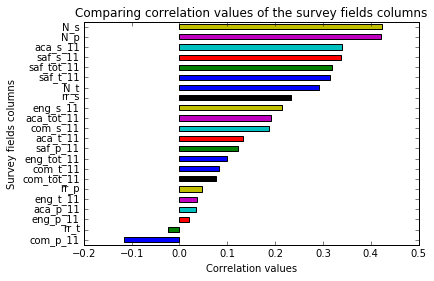

In [13]:
#create a bar plot with the columns in 'survey_fields_corrs'
survey_fields_corrs.sort_values().plot.barh(title="Comparing correlation values of the survey fields columns")
plt.xlabel('Correlation values')
plt.ylabel('Survey fields columns') 

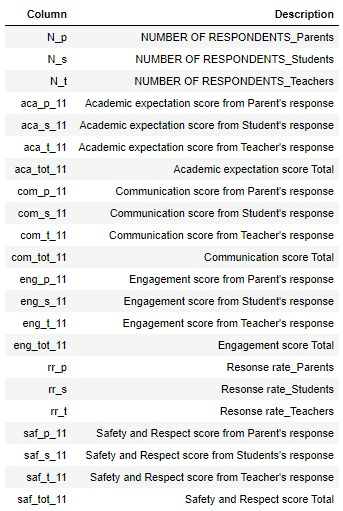

Conclusions:

1)The number of student responses (`N_s`) and the number of parent responses (`N_p`) had the two highest positive correlations with SAT scores.

2)The communication score from a parent's response (`com_p_11`) had the highest negative correlation with SAT scores.

## Investigate safety scores

Notice that `saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlate highly with `sat_score`. 

Explore those correlations and figure out which schools have low safety scores.

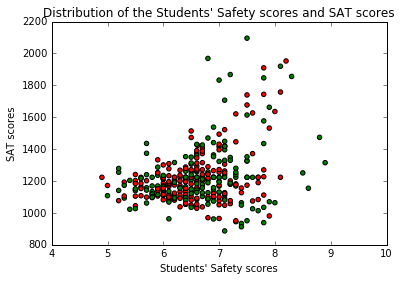

In [14]:
#Create a scatter plot of saf_s_11 vs. sat_score
combined.plot.scatter(x="saf_s_11", y="sat_score", c=['red','green'])
plt.title("Distribution of the Students' Safety scores and SAT scores")
plt.xlabel("Students' Safety scores")
plt.ylabel("SAT scores")

Conclusion:

1)There are few schools with high SAT scores and safety scores.

2)The majority of the schools have mid-range safety scores and have SAT scores below 1400. 

In [15]:
#Calculate the average safety score for each NYC neighborhood (boro)

#Group by NYC neighborhood (boro) 
#calculate the mean of each neighborhood in each column
nyc_neighborhoods = combined.groupby('boro').mean()
#Select total safety score column
#sort the values from highest to lowest total safety score
nyc_neighborhoods["saf_tot_11"].sort_values(ascending=False)


boro
Manhattan        7.473333
Queens           7.387500
Bronx            7.322581
Staten Island    7.200000
Brooklyn         7.129245
Name: saf_tot_11, dtype: float64

Conclusion:

Manhattan is the safest New York City neighborhood.

Brooklyn is the unsafest New York City neighborhood.

## Investigate racial differences in SAT scores

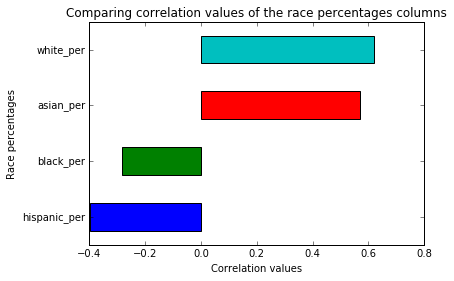

In [24]:
#assign race percentage columns to a variable
race_percentages = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

#Contains the correlations between the columns in
#'race_percentages' and the 'sat_score' column
race_percentages_corrs = correlations[race_percentages]

#create a bar plot to investigate the racial differences in SAT scores
race_percentages_corrs.sort_values().plot.barh(title="Comparing correlation values of the race percentages columns")
plt.xlabel('Correlation values')
plt.ylabel('Race percentages') 

Conclusion:

The percentage of white and asian populations are the positively correlated with the SAT scores.

The percentage of black and hispanic populations are the negatively correlated with the SAT scores.

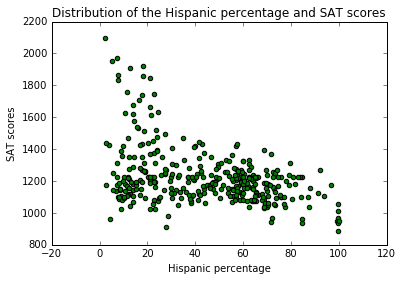

In [17]:
#create a scatter plot of hispanic_per vs. sat_score
combined.plot.scatter(x="hispanic_per", y="sat_score", c='green')
plt.title("Distribution of the Hispanic percentage and SAT scores")
plt.xlabel("Hispanic percentage")
plt.ylabel("SAT scores")

Conclusion:

The highest SAT scores were obtained at schools with a low percentage of hispanics.

The majority of schools had SAT scores of 1500 and below regardless of the percentage of hispanics.

In [18]:
#Find the schools with a hispanic_per greater than 95%

#filter combined that show schools
#with hispanic percentage greater than 95%
hispanic_95 = combined[combined["hispanic_per"] > 95]

#create a dataframe of the school names and sat scores for schools
#with a hispanic percentage greater than 95%
hispanic_schools_and_SATs = hispanic_95[["SCHOOL NAME", "hispanic_per", "sat_score"]]
print(hispanic_schools_and_SATs)


                                           SCHOOL NAME  hispanic_per  \
44                       MANHATTAN BRIDGES HIGH SCHOOL          99.8   
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL          96.7   
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...          99.8   
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY          99.4   
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS          99.8   
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE          99.8   
253                          MULTICULTURAL HIGH SCHOOL          99.8   
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL         100.0   

     sat_score  
44      1058.0  
82      1174.0  
89      1014.0  
125      951.0  
141      934.0  
176      970.0  
253      887.0  
286      951.0  


In [19]:
#Find the schools with a hispanic_per lower than 10%
#and an average SAT score greater than 1800

#filter combined that show schools
#with a hispanic_per lower than 10%
#and an average SAT score greater than 1800
hispanic_95 = combined[combined["hispanic_per"] < 10]
hispanic_95_SAT_1800 = hispanic_95[hispanic_95["sat_score"] > 1800]

#create a dataframe of the school names and sat scores for schools
#with a hispanic percentage lower than 10%
#and an average SAT score greater than 1800
hispanic_schools_and_SATs = hispanic_95_SAT_1800[["SCHOOL NAME", "hispanic_per", "sat_score"]]
print(hispanic_schools_and_SATs)

                                           SCHOOL NAME  hispanic_per  \
37                              STUYVESANT HIGH SCHOOL           2.4   
151                       BRONX HIGH SCHOOL OF SCIENCE           7.2   
187                     BROOKLYN TECHNICAL HIGH SCHOOL           7.9   
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...           7.9   
356                STATEN ISLAND TECHNICAL HIGH SCHOOL           5.3   

     sat_score  
37      2096.0  
151     1969.0  
187     1833.0  
327     1868.0  
356     1953.0  


## Investigate gender differences in SAT scores

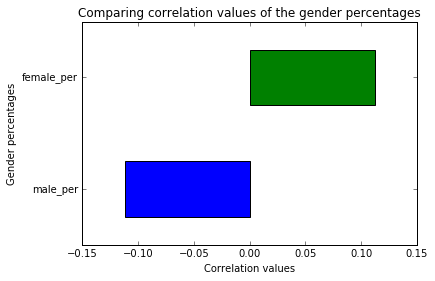

In [26]:
#assign gender percentage columns to a variable
gender_percentages = ['male_per', 'female_per']

#Contains the correlations between the columns in
#'gender_percentages' and the 'sat_score' column
gender_percentages_corrs = correlations[gender_percentages]

#create a bar plot to investigate the gender differences in SAT scores
gender_percentages_corrs.sort_values().plot.barh(title="Comparing correlation values of the gender percentages")
plt.xlabel('Correlation values')
plt.ylabel('Gender percentages') 

Conclusion:

The percentage of females is positively correlated with the SAT scores.

The percentage of males is negatively correlated with the SAT scores.

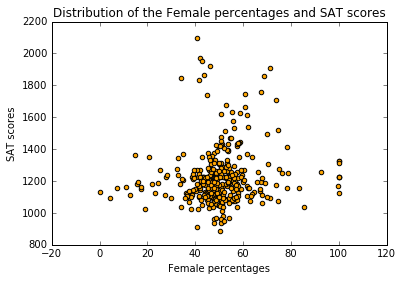

In [21]:
#create a scatter plot of female_per vs. sat_score
combined.plot.scatter(x="female_per", y="sat_score", c='orange')
plt.title("Distribution of the Female percentages and SAT scores")
plt.xlabel("Female percentages")
plt.ylabel("SAT scores")

Conclusion:

The majority of schools have a female percentage ranging from 40 - 60 and had SAT scores of 1500 and below.

In [22]:
#Find the schools with a female_per greater than 60%
#and an average SAT score greater than 1700

#filter combined that show schools
#with a female_per greater than 60%
#and an average SAT score greater than 1700
female_60 = combined[combined["female_per"] > 60]
female_60_SAT_1700 = female_60[female_60["sat_score"] > 1700]

#create a dataframe of the school names and sat scores for schools
#with a female_per greater than 60%
#and an average SAT score greater than 1700
female_schools_and_SATs = female_60_SAT_1700[["SCHOOL NAME", "female_per", "sat_score"]]
print(female_schools_and_SATs)

                                           SCHOOL NAME  female_per  sat_score
5                       BARD HIGH SCHOOL EARLY COLLEGE        68.7     1856.0
26                       ELEANOR ROOSEVELT HIGH SCHOOL        67.5     1758.0
60                                  BEACON HIGH SCHOOL        61.0     1744.0
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...        73.6     1707.0
302                        TOWNSEND HARRIS HIGH SCHOOL        71.1     1910.0


## Investigate the between AP Test Takers and SAT scores

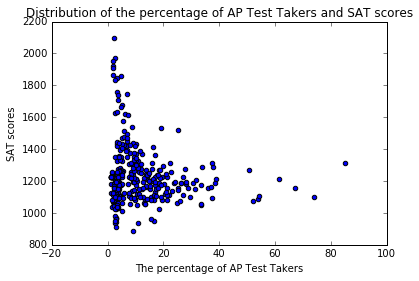

In [23]:
#Calculate the percentage of students in each school that took an AP exam
combined["ap_per"] = combined["total_enrollment"] / combined["AP Test Takers "]

#create a scatter plot of ap_per vs. sat_score
combined.plot.scatter(x="ap_per", y="sat_score", c='blue')
plt.title("Distribution of the percentage of AP Test Takers and SAT scores")
plt.xlabel("The percentage of AP Test Takers")
plt.ylabel("SAT scores")

Conclusion:

The highest SAT scores were obtained at schools with a low percentage of hispanics.

The majority of schools had most students fall between the 0 - 40 percent range of AP Test Takers. Of those students, most scored 1500 and below on the SATs.

The AP exams do not seem to prepare students for the SATs.